In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import multivariate_normal
import torch
from tqdm.notebook import tqdm

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [9]:
dataframe = pd.read_pickle('./dataframe-camera-ready.pkl')
dataframe

rows = dataframe.index.to_list()
rows = rows[:5] + rows[6:12] + rows[5:6] + rows[12:]
dataframe = dataframe.loc[rows]
rows = dataframe.index.to_list()
rows = rows[:2] + rows[4:5] + rows[2:4] + rows[7:8] + rows[5:7] + rows[10:11] + rows[8:10] + rows[11:]
dataframe = dataframe.loc[rows]
dataframe

,eq,eq-error,eq-iterations,eq-num-params,matern,matern-error,matern-iterations,matern-num-params,noisy-mixture,noisy-mixture-error,...,sawtooth,sawtooth-error,sawtooth-iterations,sawtooth-num-params,weakly-periodic,weakly-periodic-error,weakly-periodic-iterations,weakly-periodic-num-params,marker,colour
Oracle-GP,1.4708933257216295,7.86958e-05,NaN,NaN,1.3593273004151387,9.53897e-05,NaN,NaN,1.1527714750093425,0.000165449,...,NaN,NaN,NaN,NaN,0.7050805030634204,0.000202751,NaN,NaN,NaN,NaN
Oracle-GP-diag,1.2839344689919507,0.000267614,NaN,NaN,1.075070087813096,0.000322327,NaN,NaN,0.578109282547963,0.000508311,...,NaN,NaN,NaN,NaN,0.08656737279396581,0.000424399,NaN,NaN,NaN,NaN
GNP-meanfield,0.575102,0.011145861406276164,101.0,116354.0,0.25485,0.010530588261717096,101.0,116354.0,-0.81507,0.00830182109011445,...,-0.155878,0.0005141743089489149,101.0,116354.0,-1.1485,0.0030314384932142707,101.0,116354.0,s,tab:blue
GNP-innerprod-homo,1.25105,0.0010508486199375688,101.0,182274.0,1.05815,0.0011824730548815683,101.0,182274.0,0.477235,0.0011624424476749178,...,-0.155702,0.0005128634515104406,101.0,182274.0,-1.15472,0.002123157934846382,101.0,182274.0,o,tab:blue
GNP-kvv-homo,1.16419,0.0008190203937628571,101.0,182404.0,0.990386,0.0009573798430822996,101.0,182404.0,0.473012,0.000919825510349524,...,0.0301014,0.0012949562874650252,101.0,182404.0,-0.769819,0.0022162848952159185,101.0,182404.0,x,tab:blue
AGNP-meanfield,-0.758724,0.004236042016715878,101.0,740098.0,-0.850386,0.0035898690480457227,101.0,740098.0,-1.47653,0.0024911947756317853,...,-0.155853,0.000515674321166974,101.0,740098.0,-0.575173,0.009690428090896056,101.0,740098.0,s,tab:purple
AGNP-innerprod-homo,1.41516,0.0023404930584705382,101.0,806018.0,1.01785,0.000862792388253163,101.0,806018.0,-0.282944,0.0068724825104336295,...,-0.15572,0.0005127195470134297,101.0,806018.0,-1.15658,0.0020759895787119415,101.0,806018.0,o,tab:purple
AGNP-kvv-homo,1.38987,0.0024978671687815785,101.0,806148.0,1.05162,0.002101062805480478,19.0,806148.0,0.790988,0.006210303348965664,...,-0.183942,0.0003610274078651802,5.0,806148.0,-0.275138,0.008242918525471111,101.0,806148.0,x,tab:purple
convGNP-meanfield,1.2631,0.010544011188988317,101.0,50700.0,1.06094,0.013180002196442758,101.0,50700.0,0.544291,0.021601067469761214,...,1.94053,0.012836719717833825,101.0,50700.0,-0.26003,0.012788914888857708,101.0,50700.0,s,tab:olive
convGNP-innerprod-homo,1.45568,0.0021524859515825966,101.0,55300.0,1.29575,0.004380239579598201,101.0,55300.0,0.55926,0.021840879180300896,...,1.30952,0.02498968047987725,101.0,55300.0,-0.30831,0.00929066875932003,101.0,55300.0,o,tab:olive


In [12]:
def plot_all_toy_results(df):
    
    data_names = ["eq",
                  "matern",
                  "noisy-mixture",
#                   "noisy-mixture-slow",
                  "weakly-periodic",
#                   "weakly-periodic-slow",
                  "sawtooth"]
    
    titles = ["EQ",
              "Matern",
              "Noisy mixture",
#               "Noisy mixture (slow)",
              "Weakly periodic",
#               "Weakly periodic (slow)",
              "Sawtooth"]
    
    labels = ["GNP (meanfield)",
              "GNP (linear)",
              "GNP (kvv)",
              "AGNP (meanfield)",
              "AGNP (linear)",
              "AGNP (kvv)",
              "ConvGNP (meanfield)",
              "ConvGNP (linear)",
              "ConvGNP (kvv)",
              "ANP",
              "ConvNP",
              "FullConvGNP"]
    
    yticks = [np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.5, 1.0, 6),
              np.linspace(-1.5, 0.5, 5),
              np.linspace(-0.5, 2.5, 4)]
    
    markers = ["s", "s", "s"] + ["o", "o", "o"] + ["^", "^", "^"] + ["P", "X", "*"]
    triplet = [60., 60., 60.]
    marker_sizes = [60., 60., 50.] + [60., 60., 70.] + [60., 60., 80.] + [80.] + [80.] + [150.]
    
    triplet = ['tab:red', 'tab:green', 'tab:blue']
    colors = triplet * 3 + ["tab:purple"] + ["tab:purple"] + ["tab:orange"]
    
    fig = plt.figure(figsize=(14, 5))
    
    for i, d in enumerate(data_names):
        
        plt.subplot(1, len(data_names), i+1)
        
        x = np.arange(len(df[d]) + 2)
#         x = [x_ for i, x_ in enumerate(x)]
        ones = np.ones_like(x)
        y = df[d]
        e = df[d + '-error']
        oracle_result = df[d]["Oracle-GP"]
        oracle_error = df[d + "-error"]["Oracle-GP"]
        oracle_diag_result = df[d]["Oracle-GP-diag"]
        oracle_diag_error = df[d + "-error"]["Oracle-GP-diag"]

        for j in range(2, len(labels)+2):
            
            if i == len(data_names) - 1:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=0.6, edgecolor='k', zorder=2, label=labels[j-2])
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
            
            else:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=0.6, edgecolor='k', zorder=2)
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
#                 plt.setp(axis, ylim=axis[0].get_ylim())
                
#         for j in range(3):
#             idx = 2 + j + np.arange(0, 7, 3)
#             plt.plot(idx, y[idx], color='gray', zorder=1, alpha=0.3)

        plt.plot(x, oracle_result * ones, '--', label='GP Oracle', color='k', zorder=1)
        plt.plot(x, oracle_diag_result * ones, '--', label='GP Oracle (diag.)', color='tab:red', zorder=1)

        plt.xticks([])
        plt.title(titles[i], fontsize=18)
        plt.xlim([0., 14])
        
        if i == 0:
            plt.ylabel('Log. likelihood', fontsize=24)
    
        ylims = [(-1.10, 1.65),
                 (-1.10, 1.53),
                 (-1.75, 1.35),
                 (-1.75, 0.90),
                 (-0.60, 2.6)]
            
        plt.yticks(yticks[i], fontsize=14)
        plt.ylim(ylims[i])
        
        
    handles, labels = plt.gca().get_legend_handles_labels()
#     fig.legend(handles[:2], labels[:2], loc='right', ncol=2, fontsize=13)

    fig.legend(handles[:2], labels[:2], loc='lower left', ncol=1, fontsize=14, bbox_to_anchor=(0.02, 0.015, 0.10, 0.10))
    fig.legend(handles[2:], labels[2:], loc='center', ncol=4, fontsize=14, bbox_to_anchor=(0.4, 0.0, 0.4, 0.2))

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.22)
    plt.savefig("./plots/toy-results.pdf")
    plt.show()

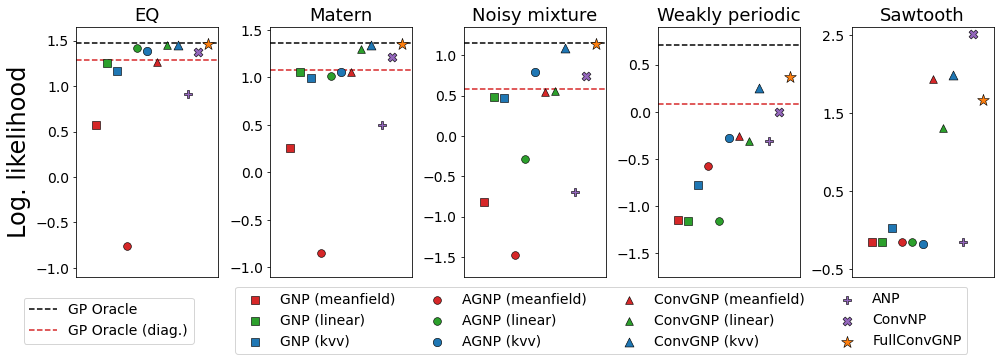

In [13]:
plot_all_toy_results(dataframe)